In [31]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Current dir
current_dir = os.getcwd()
print( f"Directorio: { current_dir }" )
# Two levels above directory
parent_dir = os.path.abspath( os.path.join( current_dir, os.path.pardir, os.path.pardir ) )
print( f"Directorio padre: { parent_dir }" )
# Path to the data
directory = parent_dir + "/Datasets/20240215a_data/names/*.txt"

def findFiles( path ): return glob.glob( path )

print( findFiles( directory ) )

Directorio: /home/xamanek/PythonProjects/ML_Transformers_001/MachineLearning/Classification
Directorio padre: /home/xamanek/PythonProjects/ML_Transformers_001
['/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Czech.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Korean.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Chinese.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/English.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Italian.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Portuguese.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/German.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Japanese.txt', '/home/xamanek/PythonProjects/ML_Transformers_001/Datasets/20240215a_data/names/Vietname

In [32]:
# Turn unicode string to plain ASCII 
def unicodeToAscii( s ):
  return ''.join(
    c for c in unicodedata.normalize( 'NFD', s )
    if unicodedata.category( c ) != 'Mn'
    and c in all_letters # This variable must be local and not being accessed from the global scope
  )

# Read a file and split into lines 
def readLines(filename):
  with open( filename, encoding = 'utf-8' ) as some_file:
    return [ unicodeToAscii( line.strip() ) for line in some_file ]

all_letters = string.ascii_letters + " .,;'-"
n_letters = len( all_letters ) + 1 # Plus EOS marker

# Build the category_lines dictionary, a list of lines per category 
category_lines = {}
all_categories = []
for filename in findFiles( directory ):
  category = os.path.splitext( os.path.basename( filename ) )[0]
  all_categories.append( category )
  lines = readLines( filename )
  category_lines[ category ] = lines

n_categories = len( all_categories )

if n_categories == 0:
  raise RuntimeError( 'Data not found. Make sure thata you downloaded data ' 
                     'from https://download.pytorch.org/tutorial/data.zip and'
                     'extract it to the current directory.')

print( '# Categories: ', n_categories, all_categories )
print( unicodeToAscii( "O'Néàl" ) )



# Categories:  18 ['Czech', 'Korean', 'Chinese', 'English', 'Italian', 'Portuguese', 'German', 'Japanese', 'Vietnamese', 'Greek', 'Polish', 'Irish', 'Spanish', 'French', 'Dutch', 'Russian', 'Scottish', 'Arabic']
O'Neal


In [33]:
class RNN( nn.Module ):
  def __init__(self, input_size, hidden_size, output_size ):
    super( RNN, self ).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear( n_categories + input_size + hidden_size, hidden_size )
    self.i2o = nn.Linear( n_categories + input_size + hidden_size, output_size )
    self.o2o = nn.Linear( hidden_size + output_size, output_size )
    self.dropout = nn.Dropout( 0.1 )
    self.softmax = nn.LogSoftmax( dim = 1 )

  def forward( self, category, input, hidden ):
    input_combined = torch.cat( ( category, input, hidden ), 1 )
    hidden = self.i2h( input_combined )
    output = self.i2o( input_combined )
    output_combined = torch.cat( ( hidden, output ), 1 )
    output = self.o2o( output_combined )
    output = self.dropout( output )
    output = self.softmax( output )
    return output, hidden
  
  def initHidden( self ):
    return torch.zeros( 1, self.hidden_size )
  

In [34]:
# Random item from a list 
def randomChoice( l ):
  return l[ random.randint( 0, len( l ) - 1 ) ]

# Get a random category and random line from that category
def randomTrainingPair():
  category = randomChoice( all_categories )
  line = randomChoice( category_lines[ category ] )
  return category, line



In [36]:
# One-hot vector for category 
def categoryTensor( category ):
  li = all_categories.index( category )
  tensor = torch.zeros( 1, n_categories )
  tensor[ 0 ][ li ] = 1
  return tensor

# One-hot matrix of first to last letters (not including EOS) for input 
def inputTensor( line ):
  tensor = torch.zeros( len( line ), 1, n_letters )
  for li in range( len( line ) ):
    letter = line[ li ]
    tensor[ li ][ 0 ][ all_letters.find( letter ) ] = 1
  return tensor

# ''LongTensor'' of second letter to end (EOS) for target 
def targetTensor( line ):
  letter_indexes = [ all_letters.find( line[ li ] ) for li in range( 1, len( line ) ) ]
  letter_indexes.append( n_letters - 1 ) # EOS
  return torch.LongTensor( letter_indexes )


In [37]:
# Make category, input and target tensors from a random category, line pair 
def randomTrainingExample():
  category, line = randomTrainingPair()
  category_tensor = categoryTensor( category )
  input_line_tensor = inputTensor( line )
  target_line_tensor = targetTensor( line )
  return category_tensor, input_line_tensor, target_line_tensor

In [38]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train( category_tensor, input_line_tensor, target_line_tensor ):
  target_line_tensor.unsqueeze_(-1)
  hidden = rnn.initHidden()

  rnn.zero_grad() # this should be a local variable and not access a global scope variable

  loss = torch.Tensor( [ 0 ] ) # It can also use ''loss = 0''

  for i in range( input_line_tensor.size( 0 ) ):
    output, hidden = rnn( category_tensor, input_line_tensor[ i ], hidden )
    l = criterion( output, target_line_tensor[ i ] )
    loss += l

  loss.backward()

  for p in rnn.parameters():
    p.data.add_( p.grad.data, alpha = -learning_rate )

  return output, loss.item() / input_line_tensor.size( 0 )

In [41]:
def timeSince( since ):
  now = time.time()
  s = now - since 
  m = math.floor( s / 60 )
  s -= m * 60
  return '%dm %ds' % ( m, s )


In [42]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ''plot_every'' ''iters'' 

start = time.time()

for iter in range( 1, n_iters + 1 ):
  output, loss = train( *randomTrainingExample() )
  total_loss += loss 

  if iter % print_every == 0:
    print( '%s ( %d %d%% ) %.4f' % ( timeSince( start ), iter, iter / n_iters * 100, loss ) )

  if iter % plot_every == 0:
    all_losses.append( total_loss / plot_every )
    total_loss = 0 

0m 11s ( 5000 5% ) 2.5909
0m 23s ( 10000 10% ) 2.8361
0m 34s ( 15000 15% ) 3.0155
0m 45s ( 20000 20% ) 2.1071
0m 56s ( 25000 25% ) 2.1845
1m 8s ( 30000 30% ) 1.8742
1m 19s ( 35000 35% ) 2.4737
1m 30s ( 40000 40% ) 2.3592
1m 41s ( 45000 45% ) 3.5806
1m 52s ( 50000 50% ) 3.1656
2m 3s ( 55000 55% ) 2.0257
2m 15s ( 60000 60% ) 2.6662
2m 26s ( 65000 65% ) 2.2241
2m 37s ( 70000 70% ) 2.4730
2m 48s ( 75000 75% ) 2.2757
3m 0s ( 80000 80% ) 2.3889
3m 10s ( 85000 85% ) 2.3911
3m 22s ( 90000 90% ) 2.4076
3m 33s ( 95000 95% ) 2.5896
3m 44s ( 100000 100% ) 2.1962


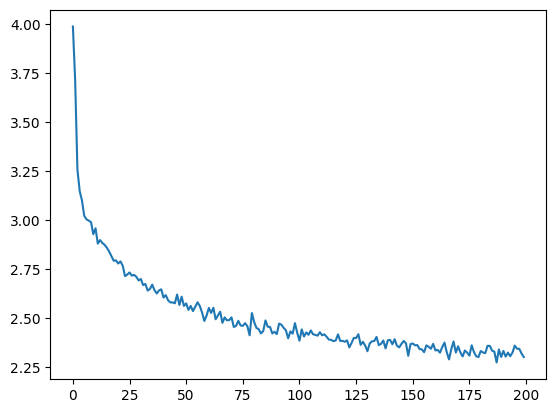

In [43]:
plt.figure()
plt.plot( all_losses )

In [45]:
max_length = 20

def sample( category, start_letter = 'A' ):
  with torch.no_grad():
    category_tensor = categoryTensor( category )
    input = inputTensor( start_letter )
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range( max_length ):
      output, hidden = rnn( category_tensor, input[ 0 ], hidden )
      topv, topi = output.topk( 1 )
      topi = topi[ 0 ][ 0 ]
      if topi == n_letters - 1:
        break
      else:
        letter = all_letters[ topi ]
        output_name += letter
      input = inputTensor( letter )
    
    return output_name
  
def samples( category, start_letters = 'ABC' ):
  for start_letter in start_letters:
    print( sample( category, start_letter ) )

samples( 'Russian', 'RUS' )
print('\n')
samples( 'German', 'GER' )
print('\n')
samples( 'Spanish', 'SPA' )
print('\n')
samples( 'Chinese', 'CHI' )
print('\n')

Roveri
Uakoveve
Santos


Gerter
Erenger
Roure


Sertan
Paner
Alla


Chan
Han
Iung


